In [29]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

data_path = Path("data")

## Basic Explo

Index(['experiment_id', 'protein_name', 'uniprot_id', 'pdb_id', 'chain',
       'position', 'wild_type', 'mutation', 'ddG', 'dTm', 'is_curated', 'type',
       'derived_type', 'interpro_families', 'conservation', 'is_essential',
       'correlated_pairs', 'back_to_consensus', 'secondary_structure', 'asa',
       'is_in_catalytic_pocket', 'tunnels', 'is_in_bottleneck', 'b_factor',
       'method', 'method_details', 'technique', 'technique_details', 'pH',
       'tm', 'notes', 'publication_doi', 'publication_pubmed', 'hsw_job_id',
       'datasets', 'sequence'],
      dtype='object')
Total no of proteins: 235 
Proteins w/ ddG values: 177 



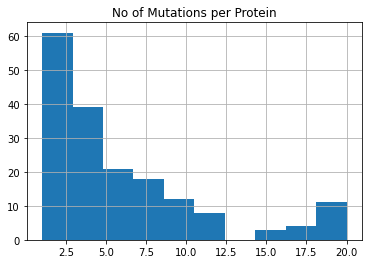

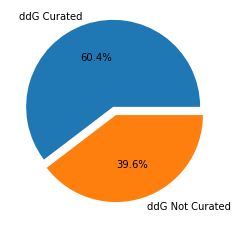

In [39]:
df = pd.read_csv(data_path / "fireprotdb_results.csv", low_memory=False)
df = df.drop_duplicates()
total_prots = len(df.sequence.unique())

df = df[df.ddG.isin(df.ddG.dropna())]
ddg_prots = len(df.sequence.unique())

mutations_per_prot = df.groupby(by="sequence").mutation.unique()

print(df.columns)
print(f"Total no of proteins: {total_prots} \nProteins w/ ddG values: {ddg_prots} \n")

ax = mutations_per_prot.apply(len).hist()
ax.set_title("No of Mutations per Protein");
plt.show() 

y = [df.is_curated.sum(), len(df) - df.is_curated.sum()]
explode = (0.1, 0)
labels = ("ddG Curated","ddG Not Curated")

plt.pie(y, explode=explode, labels=labels, autopct='%1.1f%%')
plt.show() 

In [49]:
df.technique_details.unique()

array([nan, 'Fluorescence', 'CD', 'DSC', 'HPLC', 'Absorbance', 'NMR',
       'Gel electrophoresis', 'ESR', 'CD, Fluorescence', 'CD (far-UV)',
       'Hydrogen exchange', 'Isothermal denaturation', 'Chromatography',
       'Absorbance, CD, Fluorescence',
       'CD, Fluorescence, Thiol reactivity', 'Pulse protolysis'],
      dtype=object)

In [50]:
df.head()

,experiment_id,protein_name,uniprot_id,pdb_id,chain,position,wild_type,mutation,ddG,dTm,...,technique,technique_details,pH,tm,notes,publication_doi,publication_pubmed,hsw_job_id,datasets,sequence
565,LL000714,Immunoglobulin G-binding protein G,P06654,1PGA,A,1,M,A,-0.14,NaN,...,NaN,NaN,6.5,NaN,NaN,10.1073/pnas.1903888116,31371509.0,2i1nqi,NaN,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...
567,LL000715,Immunoglobulin G-binding protein G,P06654,1PGA,A,1,M,D,-0.38,NaN,...,NaN,NaN,6.5,NaN,NaN,10.1073/pnas.1903888116,31371509.0,2i1nqi,NaN,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...
569,LL000716,Immunoglobulin G-binding protein G,P06654,1PGA,A,1,M,E,-0.64,NaN,...,NaN,NaN,6.5,NaN,NaN,10.1073/pnas.1903888116,31371509.0,2i1nqi,NaN,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...
571,LL000717,Immunoglobulin G-binding protein G,P06654,1PGA,A,1,M,F,-1.14,NaN,...,NaN,NaN,6.5,NaN,NaN,10.1073/pnas.1903888116,31371509.0,2i1nqi,NaN,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...
573,LL000718,Immunoglobulin G-binding protein G,P06654,1PGA,A,1,M,G,-0.30,NaN,...,NaN,NaN,6.5,NaN,NaN,10.1073/pnas.1903888116,31371509.0,2i1nqi,NaN,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...


## Get Mutations Sequences

In [4]:
sequences = []# set()

#TODO: TEST IF MUTATION IS CORRECT
nans = 0
for row in tqdm(df.itertuples(), total = len(df)):
    mutation = row.mutation
    position = row.position
    original_seq = row.sequence

    new_sequence = original_seq[:position - 1] + mutation + original_seq[position:]
    if mutation == original_seq[position - 1] or str(new_sequence) == str(original_seq) or (new_sequence in sequences):
        # print(row.Index)
        new_sequence = None
        nans += 1
    sequences.append(new_sequence)

df["mutated_sequences"] = sequences

100%|██████████| 12133/12133 [00:00<00:00, 29326.83it/s]


In [5]:
len(sequences), len(set(sequences)) # same protein and same mutation multiple times? w/ different values? how can this be possible?? ==> see: https://loschmidt.chemi.muni.cz/fireprotdb/mutation/6154

(12133, 5174)

## Filtering to extract embeddings

In [6]:
data = df[["mutated_sequences", "ddG"]]
data.columns = ["sequences", "labels"]
data = data[data["sequences"].str.len() < 1000]
data = data[data.columns[::-1]]
data = data.dropna()

data, len(data)

(       labels                                          sequences
 565     -0.14  AEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...
 567     -0.38  DEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...
 569     -0.64  EEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...
 571     -1.14  FEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...
 573     -0.30  GEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...
 ...       ...                                                ...
 16966    0.10  MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...
 16968    1.20  MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...
 16969    0.50  MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...
 16970    0.10  MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...
 16971   -0.40  MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...
 
 [4950 rows x 2 columns],
 4950)

In [7]:
len(data.sequences.unique())

4950

## Embedding Extraction + H5 Dataset

In [8]:
from protera_stability.data import ProteinStabilityDataset
from protera_stability.proteins import EmbeddingExtractor1D

args_dict = {
    "model_name": "esm1b_t33_650M_UR50S",
    "base_path": data_path,
    "gpu": True,
}
emb_extractor = EmbeddingExtractor1D(**args_dict)
embeddings = emb_extractor.generate_embeddings(
    [""],
    data=data,
    path_out=f"embeddings_fireprot",  # data_path / "embeddings_fireprot".pkl
    bs=16,
)

# dataset = ProteinStabilityDataset(data_path / f"stability_fireprot.h5",  ret_dict=False)
# len(dataset)

Using cache found in /home/roberto/.cache/torch/hub/facebookresearch_esm_master
100%|██████████| 310/310 [04:39<00:00,  1.11it/s]

Embeddings saved to data/embeddings_fireprot.pkl


In [9]:
dataset = emb_extractor.generate_datasets(
    [""],
    h5_stem="stability_fireprot",
    embedding_file=f"embeddings_fireprot",  # data_path / "embeddings_fireprot".pkl
    data=data
)

In [14]:
dataset.keys(), len(dataset["embeddings"])

(<KeysViewHDF5 ['embeddings', 'labels', 'sequences']>, 4950)

In [12]:
dataset["embeddings"][:5], dataset["labels"][:5], dataset["sequences"][:5]

(array([[ 0.19025522,  0.14569299,  0.02341236, ...,  0.16723429,
         -0.08888589, -0.22014013],
        [ 0.19511746,  0.14424276,  0.01736344, ...,  0.18216354,
         -0.08481154, -0.21608275],
        [ 0.19187498,  0.134508  ,  0.0208389 , ...,  0.17934534,
         -0.08972536, -0.20960516],
        [ 0.2015402 ,  0.14543055,  0.02835188, ...,  0.15953344,
         -0.07038902, -0.23594014],
        [ 0.20418431,  0.12828985,  0.02565991, ...,  0.17147793,
         -0.08287086, -0.23163441]], dtype=float32),
 array([-0.14, -0.38, -0.64, -1.14, -0.3 ]),
 array([b'AEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRNGGELTNLLGNSETTLALRNEESATADLTAAAVADTVAAAAAENAGAAAWEAAAAADALAKAKADALKEFNKYGVSDYYKNLINNAKTVEGIKDLQAQVVESAKKARISEATDGLSDFLKSQTPAEDTVKSIELAEAKVLANRELDKYGVSDYHKNLINNAKTVEGVKELIDEILAALPKTDTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTEKPEVIDASELTPAVTTYKLVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGVWTYDDATKTFTVTEMVTEVPGDAPTEPEKPEASIPLVPLTPATPIAKDDAKKDDTKKEDAKKPEAKKDDAKKAETLPTTG